In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from seam import nino34, precip, utils

%load_ext autoreload
%autoreload 2

In [2]:
def get_running_corr(array1, array2, window=13, min_periods=5, center=True):
    """Define a mini function to apply a rolling correlation coefficient
    over a 7-year window"""
    s1 = pd.Series(array1)
    s2 = pd.Series(array2)
    corr = s1.rolling(window, min_periods=min_periods, center=center).corr(s2)
    ds = xr.Dataset({"corr": corr.values})
    ds["time"] = array1.time
    clean_ds = ds.reset_index("corr").reset_coords()
    return clean_ds

In [3]:
def get_obs_precip_anomalies(dir, file, months, detrend=False):
    ds0 = utils.get_ds(dir + file)
    precip_ds = ds0.sel(time=slice("1951-01", "2015-12"))
    precip_da = precip_ds["precip"]
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            precip_da,
            detrend=detrend,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True,
        ))

    precip_MAM = precip_anm.sel(time=precip_anm.time.dt.season=="MAM")
    precip_anm = precip_MAM.resample(time="1Y").mean()
    return precip_anm


def get_obs_sst_anomalies(dir, file, detrend=False):
    ds0 = utils.get_ds(dir + file)
    sst_ds = ds0.sel(time=slice("1951-01", "2015-12"))
    sst_da = sst_ds["sst"]
    sst_anm_nino34_ersst = nino34.get_nino34_anm_timeseries(
        sst_da, detrend=detrend, base_start='1951-01',
        base_end='2015-12', filtered=True
    )
    sst_season = (
        sst_anm_nino34_ersst.resample(time="QS-DEC", label="left")
        .mean(dim='time')
        .sel(time=slice("1951-01", "2015-12"))
    )  # take quarterly means starting Dec 1
    nino34_DJF_ersst = (
        sst_season.sel(time=sst_season.time.dt.month.isin([12]))
        .resample(time="1Y")
        .mean()
    )
    return nino34_DJF_ersst

In [4]:
# Open all precip. datasets
precip_anm_G = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/", 
    file="precip.mon.total.0.5x0.5.v2020.nc", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_C = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/", 
    file="cru_ts4.06.1901.2021.pre.dat.nc", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_A = get_obs_precip_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/", 
    file="APHRO_MA_050deg_V1101_EXR1.1951-2015.mm_per_month.nc", 
    months=[3, 4, 5], detrend=False
    )



In [5]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/",
    file="sst.mnmean.v5.nc",
    detrend=False
)

sst_anm_nino34_H = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/",
    file="HadISST_sst.nc",
    detrend=False
)

sst_anm_nino34_C = get_obs_sst_anomalies(
    dir="/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/",
    file="sst.mon.mean.nc",
    detrend=False
)

In [6]:
precip_anms = [
    precip_anm_G,
    precip_anm_G,
    precip_anm_G,
    precip_anm_C,
    precip_anm_C,
    precip_anm_C,
    precip_anm_A,
    precip_anm_A,
    precip_anm_A
]

sst_anm_nino34s = [
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C,
    sst_anm_nino34_E,
    sst_anm_nino34_H,
    sst_anm_nino34_C
]

In [7]:
# Figure S1a: N = 7

N=7
crit_N7 = 0.551
corr_lead_nino34s = []
for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    corr_lead_nino34 = get_running_corr(sst_anm_nino34.shift(time=1), precip_anm, window=N)
    corr_lead_nino34s.append(corr_lead_nino34.corr)

corr_lead_nino34s_da = xr.concat(corr_lead_nino34s, dim='datasets')
max_N7 = corr_lead_nino34s_da.max(dim='datasets')
min_N7 = corr_lead_nino34s_da.min(dim='datasets')
mean_N7 = corr_lead_nino34s_da.mean(dim='datasets')

# Figure S1a: N = 21

N=21
crit_N21 = 0.369
corr_lead_nino34s = []
for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    corr_lead_nino34 = get_running_corr(sst_anm_nino34.shift(time=1), precip_anm, window=N)
    corr_lead_nino34s.append(corr_lead_nino34.corr)

corr_lead_nino34s_da = xr.concat(corr_lead_nino34s, dim='datasets')
max_N21 = corr_lead_nino34s_da.max(dim='datasets')
min_N21 = corr_lead_nino34s_da.min(dim='datasets')
mean_N21 = corr_lead_nino34s_da.mean(dim='datasets')

In [8]:
def plot_ENSO_monsoon_runcorr(dates, mean, max, min, ax, crit):
    ax.plot(
        dates,
        mean,
        linestyle='-',
        color='red',
        linewidth=1,
        label="Mean"
    )

    ax.fill_between(
            dates,
            min, 
            max, 
            color='grey', 
            alpha=0.5,
            label="Range"
        )

    ax.legend(fontsize=6, frameon=False, loc=[0.75,0.6])


    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Draw 90% confidence level for correlation coefficient of length 13-years
    ax.axhline(-crit, color="grey", linestyle='--', label=None, linewidth=0.5)
    ax.axhline(+crit, color="grey", linestyle='--', label=None, linewidth=0.5)

    # Shade in grey negative periods of the IPO (determined how?)
    ax.axvspan('1948', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
    #ax2.axvspan('1969', '1977', alpha=0.2, facecolor='grey', edgecolor=None)
    ax.axvspan('1999', '2023', alpha=0.2, facecolor='grey', edgecolor=None)

    # Adding "+IPO" in the middle of each grey box at the top
    grey_midpoints = [datetime(1966, 1, 1), datetime(2011, 1, 1)]
    for midpoint in grey_midpoints:
        ax.text(midpoint, 1, '-IPO', ha='center', va='top', fontsize=6, transform=ax.get_xaxis_transform())

    # Adding "-IPO" in the middle of each white space at the top
    white_midpoints = [datetime(1988, 1, 1)]
    for midpoint in white_midpoints:
        ax.text(midpoint, 1, '+IPO', ha='center', va='top', fontsize=6, transform=ax.get_xaxis_transform())

    # Draw horizontal line at 0
    ax.axhline(0, color="grey", linewidth=1, label=None)

    # Set x- and y- labels and axes
    ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=10))

    ax.set_xlim(pd.Timestamp("1950-01-01"), pd.Timestamp("2016-12-01"))
    ax.set_ylim([-1,0.75])

    ax.set_ylabel(None)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set tick params for ax1


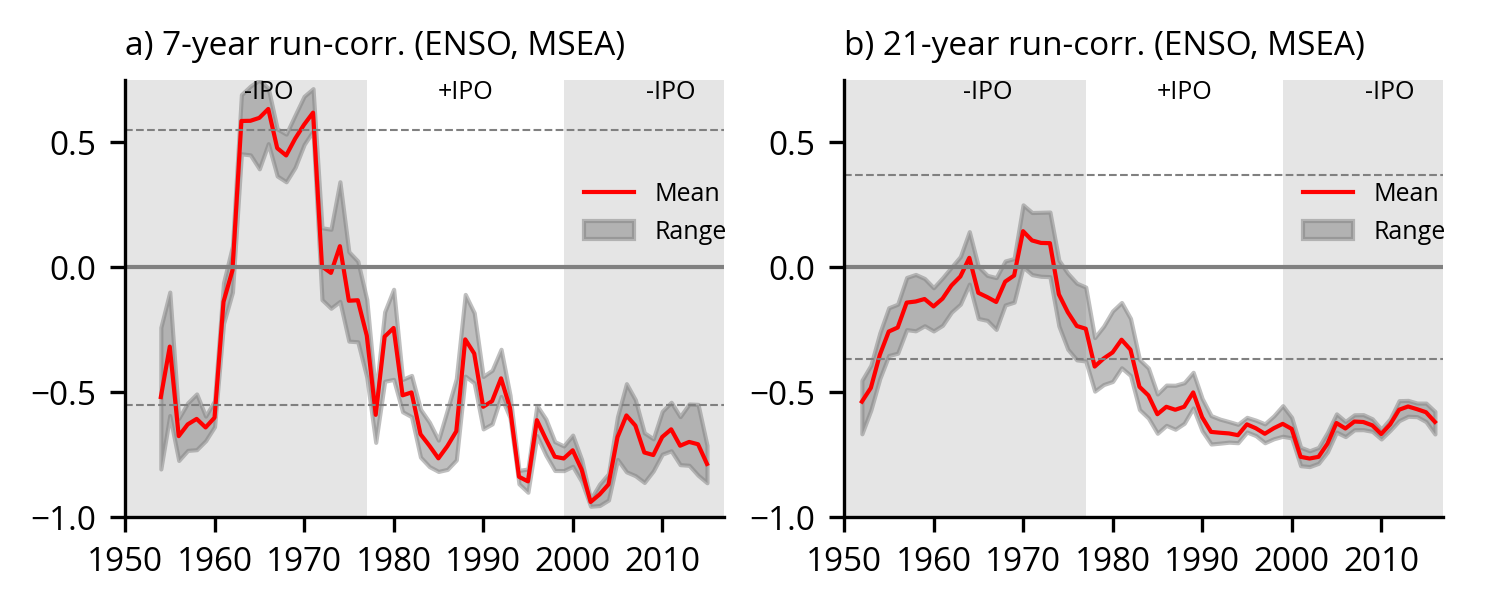

In [15]:
from datetime import datetime

utils.set_matplotlib_font("Open Sans")

color = 'black'

mpl.rcParams.update({
    'axes.edgecolor': color,      # Color of the axes spines
    'xtick.color': color,         # Color of the x-axis ticks
    'ytick.color': color,         # Color of the y-axis ticks
    'xtick.labelcolor': color,    # Color of the x-axis tick labels
    'ytick.labelcolor': color,    # Color of the y-axis tick labels
    'grid.color': color,          # Color of the grid lines
    'axes.labelcolor': color,     # Color of the axis labels
    'axes.titlecolor': color,     # Color of the plot titles
})

mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 12 
fig_height_cm = 5
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)

gs1 = GridSpec(1, 2, top=0.89, bottom=0.15, left=0.06, right=0.99, wspace=0.2, width_ratios=[0.5, 0.5])
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])

############## Figure 1b ##############
N = 13
crit = 0.497 # critical r-value at 90% confidence level

dates0 = np.array(['1951-12-31T00:00:00.000000000', '1952-12-31T00:00:00.000000000',
                  '1953-12-31T00:00:00.000000000', '1954-12-31T00:00:00.000000000',
                  '1955-12-31T00:00:00.000000000', '1956-12-31T00:00:00.000000000',
                  '1957-12-31T00:00:00.000000000', '1958-12-31T00:00:00.000000000',
                  '1959-12-31T00:00:00.000000000', '1960-12-31T00:00:00.000000000',
                  '1961-12-31T00:00:00.000000000', '1962-12-31T00:00:00.000000000',
                  '1963-12-31T00:00:00.000000000', '1964-12-31T00:00:00.000000000',
                  '1965-12-31T00:00:00.000000000', '1966-12-31T00:00:00.000000000',
                  '1967-12-31T00:00:00.000000000', '1968-12-31T00:00:00.000000000',
                  '1969-12-31T00:00:00.000000000', '1970-12-31T00:00:00.000000000',
                  '1971-12-31T00:00:00.000000000', '1972-12-31T00:00:00.000000000',
                  '1973-12-31T00:00:00.000000000', '1974-12-31T00:00:00.000000000',
                  '1975-12-31T00:00:00.000000000', '1976-12-31T00:00:00.000000000',
                  '1977-12-31T00:00:00.000000000', '1978-12-31T00:00:00.000000000',
                  '1979-12-31T00:00:00.000000000', '1980-12-31T00:00:00.000000000',
                  '1981-12-31T00:00:00.000000000', '1982-12-31T00:00:00.000000000',
                  '1983-12-31T00:00:00.000000000', '1984-12-31T00:00:00.000000000',
                  '1985-12-31T00:00:00.000000000', '1986-12-31T00:00:00.000000000',
                  '1987-12-31T00:00:00.000000000', '1988-12-31T00:00:00.000000000',
                  '1989-12-31T00:00:00.000000000', '1990-12-31T00:00:00.000000000',
                  '1991-12-31T00:00:00.000000000', '1992-12-31T00:00:00.000000000',
                  '1993-12-31T00:00:00.000000000', '1994-12-31T00:00:00.000000000',
                  '1995-12-31T00:00:00.000000000', '1996-12-31T00:00:00.000000000',
                  '1997-12-31T00:00:00.000000000', '1998-12-31T00:00:00.000000000',
                  '1999-12-31T00:00:00.000000000', '2000-12-31T00:00:00.000000000',
                  '2001-12-31T00:00:00.000000000', '2002-12-31T00:00:00.000000000',
                  '2003-12-31T00:00:00.000000000', '2004-12-31T00:00:00.000000000',
                  '2005-12-31T00:00:00.000000000', '2006-12-31T00:00:00.000000000',
                  '2007-12-31T00:00:00.000000000', '2008-12-31T00:00:00.000000000',
                  '2009-12-31T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
                  '2011-12-31T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
                  '2013-12-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
                  '2015-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

dates = dates0.astype('datetime64[D]').astype(datetime)

plot_ENSO_monsoon_runcorr(dates, mean_N7, max_N7, min_N7, ax1, crit_N7)
plot_ENSO_monsoon_runcorr(dates, mean_N21, max_N21, min_N21, ax2, crit_N21)

# Set subplot labels
titles = ["a) 7-year run-corr. (ENSO, MSEA)", "b) 21-year run-corr. (ENSO, MSEA)"]
for i, (ax, title) in enumerate(zip([ax1, ax2], titles)):
    ax.set_title(title, loc="left", fontsize=8)


plt.savefig("FigS1.png")
plt.savefig("FigS1.pdf")
